In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import statistics
import cv2
from PIL import Image
import scipy.signal as signal
import time
from joblib import Parallel, delayed

In [13]:
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    #return imageio.imread(f'./data/sequences/{group}-{student}.tif')
    return imageio.imread(f'../../{group}-{student}.nosync.tif')

In [14]:
images = load_images(9,3)

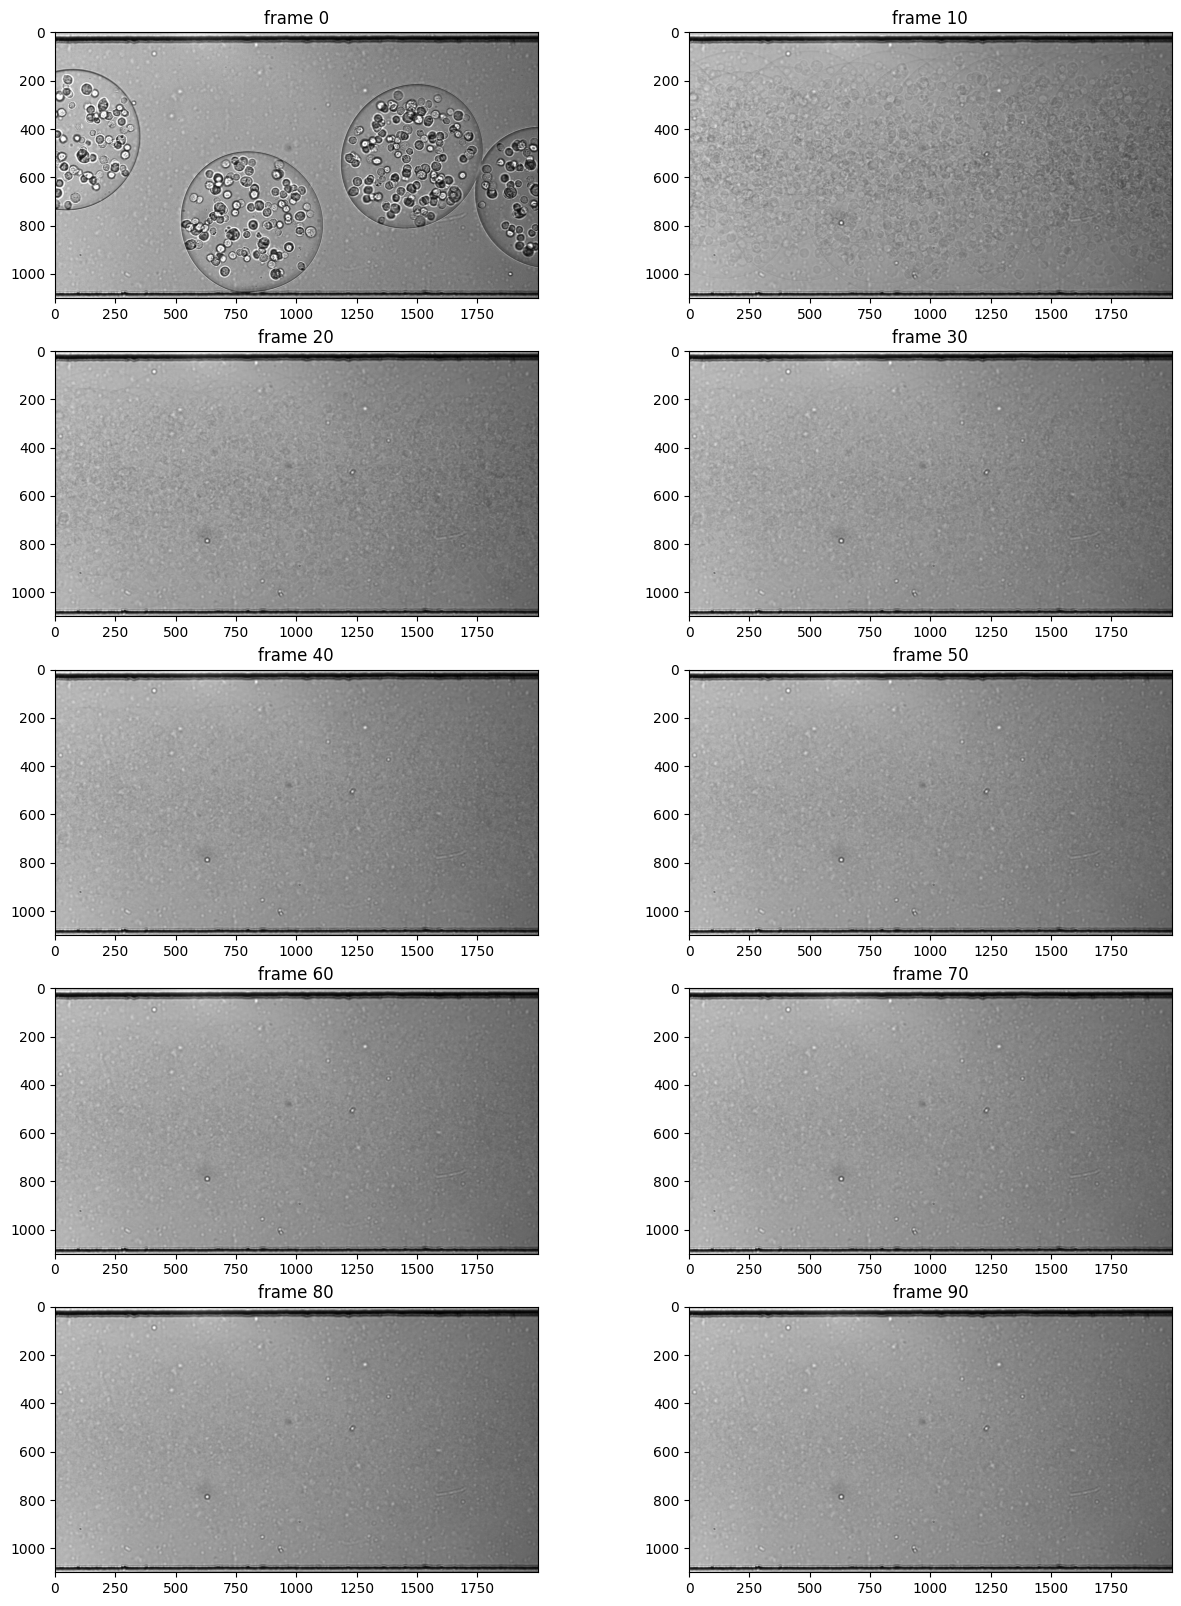

In [15]:
# Background frame by averaging

background = np.zeros((10,images.shape[1],images.shape[2]))
images_mean = np.mean(images,axis=3)
background[0] = np.mean(images_mean[:1],axis=(0))

for i in range(1,10):
    background[i] = np.mean(images_mean[:10*i],axis=(0))

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(background[i], cmap='gray')
    axs[i//2,i%2].set_title(f'frame {i*10}')
plt.show()

In [16]:
def convolve_2D(array,filter):
    fx = filter.shape[0]
    fy = filter.shape[1]
    result = np.zeros((array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if i>=fx//2 and i+fx//2+1 < array.shape[0] and j>=fy//2 and j+fy//2+1 < array.shape[1]:
                result[i,j] = np.sum((np.multiply(array[i-fx//2:i+fx//2+1,j-fy//2:j+fy//2+1],filter) + array[i,j])**2)
            else:
                sfx = 0
                efx = fx
                if i>=fx//2:
                    startx = i-fx//2 
                else: 
                    startx = 0
                    sfx += fx//2-i
                if i+fx//2+1 < array.shape[0]:
                    endx = i+fx//2+1
                else:
                    endx = array.shape[0]
                    efx -= i+fx//2+1-array.shape[0]
                sfy = 0
                efy = fy
                if j>=fy//2:
                    starty = j-fy//2 
                else: 
                    starty = 0
                    sfy += fy//2-j
                if j+fy//2+1 < array.shape[1]:
                    endy = j+fy//2+1
                else:
                    endy = array.shape[1]
                    efy -= j+fy//2+1-array.shape[1]

                result[i,j] = np.sum((np.multiply(array[startx:endx,starty:endy],filter[sfx:efx,sfy:efy]) + array[i,j])**2)
    return result

def column_energy_integrated_2d_bis(image, previous = 1):
    filter = np.ones((2*previous+1,2*previous+1))*-1
    filter[previous][previous] = 0
    filtered_image = convolve_2D(image, filter)
    return np.sum(filtered_image, axis=0)

In [17]:
# Background frame by 2D energy
nb_samples = 30
square_diff_2d = []
indexes_square_2d = []
images_sample = images_mean[0:nb_samples]
for index, image in enumerate(images_sample):
    energy = column_energy_integrated_2d_bis(image, previous=2)
    for col in range(image.shape[1]):
        if index == 0:
            square_diff_2d.append(energy[col])
            indexes_square_2d.append(0)
        else:
            if square_diff_2d[col] > energy[col]:
                square_diff_2d[col] = energy[col]
                indexes_square_2d[col] = index
    print(index)

# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_sample[indexes_square_2d[j],i,j]

# Energy image
img = Image.fromarray(background_energy, 'RGB')
img.show()

0
1
2


KeyboardInterrupt: 

In [18]:
# Background frame by variance

nb_samples = 20
indexes = []
images_mean = np.mean(images,axis=3)
images_nobound = images_mean[:nb_samples,100:-80,:]
keep = True
index = 0

mean = np.mean(images_nobound)
images_test = (images_nobound - mean)**4
column_mean = np.mean(images_test, axis=1)
indexes = []

for i in range(column_mean.shape[1]):
    indexes.append(list(zip(*np.where(column_mean[:,i]==min(column_mean[:,i])))))

background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_mean[int(indexes[j][0][0]),i,j]

img = Image.fromarray(background_energy, 'RGB')
img.show()  

In [19]:
# Naive method numpy BRODCAST

show = False

nb_sample = 100
threshold = 30
back = background[9]

start_time = time.time()
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))
back = np.broadcast_to(back, (nb_sample, images.shape[1],images.shape[2]))
masks[threshold < abs(images_mean - back)] = 1
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')


--- Execution time = 2.544857978820801 seconds ---
--- Frame rate 0.025448579788208008 seconds/frame ---
--- Frame rate 39.2949236587012 frame/seconds ---


In [20]:
# Naive method LOOP not parallelized

show = False

nb_sample = 100
threshold = 0.2
back = background[9]
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))

start_time = time.time()
for i in range(nb_sample):
    im = images_mean[i]
    masks[i] =  (abs(im - back) / np.max(im)) > threshold
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')

--- Execution time = 1.923536777496338 seconds ---
--- Frame rate 0.019235367774963378 seconds/frame ---
--- Frame rate 51.98756850917054 frame/seconds ---


In [21]:
# Naive method LOOP parallelized

show = False

nb_sample = 100
threshold = 0.2
back = background[9]
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))


def process(i,images_mean,back):
    im = images_mean[i]
    masks[i] =  (abs(im - back) / np.max(im)) > threshold
    return masks[i]

start_time = time.time()  
results = Parallel(n_jobs=-1, prefer="threads")(delayed(process)(i,images_mean,back) for i in range(nb_sample))
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')

--- Execution time = 1.0289418697357178 seconds ---
--- Frame rate 0.010289418697357177 seconds/frame ---
--- Frame rate 97.18722013487978 frame/seconds ---


### Vibe algorithm based on the paper from M. Van Droogenbroeck and O. Barnich. "ViBe: A Disruptive Method for Background Subtraction." In T. Bouwmans, F. Porikli, B. Hoferlin, and A. Vacavant, editors, Background Modeling and Foreground Detection for Video Surveillance, chapter 7. Chapman and Hall/CRC, June 2014. disponible at the adress: http://www.telecom.ulg.ac.be/publi/publications/mvd/VanDroogenbroeck2014ViBe/

In [22]:
# Vibe algorithm function

def vibe(image, nb_sample, min_match, threshold, samples, learning = True, learning_rate = 0.1, neighboor = True):
    
    result = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
    inter = np.zeros((image.shape[0],image.shape[1],nb_sample),dtype=np.uint8)
    distances = np.tile(image[:, :, np.newaxis], nb_sample)
    distances = np.abs(distances - samples)
    inter[distances < threshold] = 1
    result = np.sum(inter,axis=2)
    mask = result < min_match
    if learning:
        rand = np.random.rand(image.shape[0],image.shape[1])
        place = np.random.randint(0,nb_sample,(image.shape[0],image.shape[1]))
        # update background at location
        update = rand < learning_rate
        samples[update,place[update]] = image[update]
        # updeate background in neighborhood
        if neighboor:
            rand = np.random.rand(image.shape[0],image.shape[1])
            r1 = np.random.randint(-1,2)
            r2 = np.random.randint(-1,2)
            place_neighboor = np.random.randint(0,nb_sample,(image.shape[0],image.shape[1]))
            update_neighborhood = rand < learning_rate
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    if update_neighborhood[i,j]:
                        r1 = np.random.randint(-1,2)
                        if i+r1 < 0 or i+r1 >= image.shape[0]:
                            r1 = 0
                        r2 = np.random.randint(-1,2)
                        if j+r2 < 0 or j+r2 >= image.shape[1]:
                            r2 = 0
                        samples[i+r1,j+r2,place_neighboor[i,j]] = image[i,j]

    return mask,samples


0
10
20
30
40
50
60
70
80
90


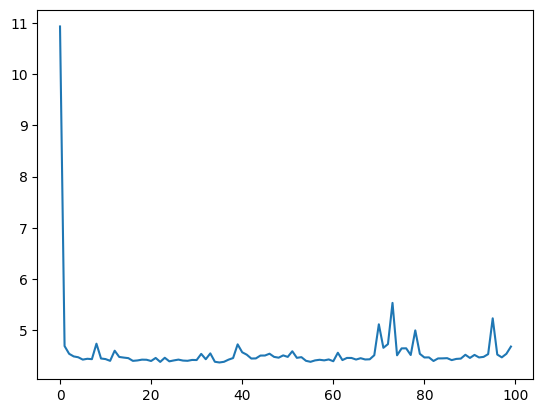

In [23]:
# Vibe algorithm without learning

show = False

nb_sample = 100
mask = np.zeros((nb_sample,images.shape[1],images.shape[2]),dtype=np.uint8)
back = background[9]
samples = np.tile(back[:, :, np.newaxis], nb_sample)
exec_time = np.zeros(100)
for i in range(nb_sample):
    start_time = time.time()
    mask[i], samples = vibe(images_mean[i], nb_sample, 2, 40, samples, learning = False)
    exec_time[i] = time.time() - start_time
    if i%10 == 0:
        print(i)
if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(mask[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')
plt.plot(exec_time)

0
10
20
30
40
50
60
70
80
90


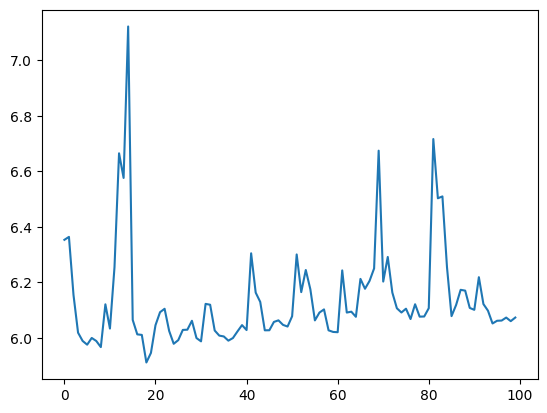

In [24]:
# Vibe algorithm with learning

show = False

nb_sample = 100
mask = np.zeros((nb_sample,images.shape[1],images.shape[2]),dtype=np.uint8)
back = background[9]
samples = np.tile(back[:, :, np.newaxis], nb_sample)
exec_time_with_learning = np.zeros(100)

for i in range(nb_sample):
    start_time = time.time()
    mask[i], samples = vibe(images_mean[i], nb_sample, 2, 40, samples, learning = True)
    exec_time_with_learning[i] = time.time() - start_time
    if i%10 == 0:
        print(i)
if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(mask[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')
plt.plot(exec_time_with_learning)

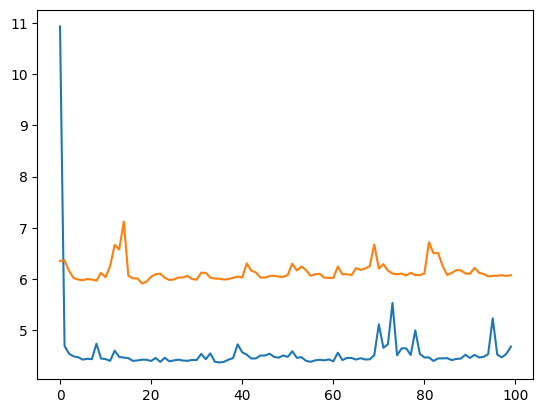

In [28]:
plt.plot(np.arange(100),exec_time,np.arange(100),exec_time_with_learning)